In [4]:
import pandas as pd
import json
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [5]:
def get_df_from_log(log_fn="tune_2021-09-30 20-05-47.184587.log"):

    res = []

    file = open(log_fn)
    lines = file.readlines()

    cnt = 0
    c = {}
    for index, line in enumerate(lines):
        line = line.replace("'", "\"")
        line = line.replace("None", "0")
        if "result" in line:
            cnt = cnt + 1

            line = line.strip().replace('result: ', '')
            line = line.strip().replace('result:', '')
            line = line.replace("'", "\"")
            line = line.replace("None", "0")
            #print("{}".format(line))
            d = json.loads(line)
            #print(d)

            dd = {            
                'trial': cnt,
                'score': d['score'],
                'duration': d['duration'],
            }

            dd.update(c)

            res.append(dd)

        else:
            line = re.sub(r'trial \d+ config: ', '', line)
            c = json.loads(line)

    file.close()


    df = pd.DataFrame(res)

    df['elapsed'] = df['duration'].cumsum()
    #df = df[df['score'] >= 0.8]


    df['is_new_best'] = 0 
    mmax = 0
    for i, row in df.iterrows():
        if row['score'] > mmax:
            mmax = row['score']
            df.at[i,'is_new_best'] = 1
            
    return df
       

# No Early Stopping

In [6]:
df_no_es = get_df_from_log(log_fn="logs/tune_2021-09-30 20-05-47.184587.log")
df_no_es.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trial              192 non-null    int64  
 1   score              192 non-null    float64
 2   duration           192 non-null    float64
 3   num_leaves         192 non-null    int64  
 4   min_child_samples  192 non-null    int64  
 5   learning_rate      192 non-null    float64
 6   max_bin            192 non-null    int64  
 7   colsample_bytree   192 non-null    float64
 8   reg_alpha          192 non-null    float64
 9   reg_lambda         192 non-null    float64
 10  n_estimators       192 non-null    int64  
 11  elapsed            192 non-null    float64
 12  is_new_best        192 non-null    int64  
dtypes: float64(7), int64(6)
memory usage: 19.6 KB


In [7]:
df_no_es.head()

,trial,score,duration,num_leaves,min_child_samples,learning_rate,max_bin,colsample_bytree,reg_alpha,reg_lambda,n_estimators,elapsed,is_new_best
0,1,0.698044,1.958881,4,20,1.000000,8,0.100000,0.000977,1.000000,4,1.958881,1
1,2,0.792834,2.026810,4,19,1.000000,8,0.183418,0.000977,0.724257,4,3.985691,1
2,3,0.699615,1.946631,4,20,0.442065,18,0.100000,0.014263,1.000000,5,5.932323,0
3,4,0.829855,2.208600,12,19,0.640579,18,0.350540,0.000977,1.978850,4,8.140923,1
4,5,0.804552,2.254045,4,19,1.000000,8,0.183418,0.002658,0.724257,6,10.394968,0


In [8]:
df_no_es.sort_values('score', ascending=False).head(10)

,trial,score,duration,num_leaves,min_child_samples,learning_rate,max_bin,colsample_bytree,reg_alpha,reg_lambda,n_estimators,elapsed,is_new_best
144,145,0.859634,300.825962,48,33,0.003640,12,0.396822,0.414945,0.000977,2518,6621.333306,1
174,175,0.859547,698.723779,42,15,0.001935,8,0.441458,0.968771,0.005064,6045,20916.214438,0
162,163,0.859530,179.090135,27,56,0.009015,22,0.387262,0.107774,0.006510,1836,14937.696104,0
188,189,0.859374,1231.196175,28,26,0.001598,15,0.414882,0.096715,0.005031,12449,28399.938542,0
125,126,0.859323,120.583656,21,23,0.009684,24,0.402988,0.048975,0.000977,1247,4011.955529,1
114,115,0.859154,101.678868,15,43,0.013757,14,0.438438,0.171032,0.005460,1060,2371.730935,1
126,127,0.859020,98.901103,15,44,0.013757,14,0.438438,0.171032,0.012046,1060,4110.856632,0
165,166,0.858999,92.341398,44,38,0.015312,9,0.487951,0.450874,0.000977,782,15715.576303,0
132,133,0.858961,69.632910,36,21,0.018137,13,0.511097,0.704995,0.001423,612,4887.518721,0
100,101,0.858909,38.856495,20,30,0.028257,24,0.415949,0.030199,0.041432,370,1717.030272,1


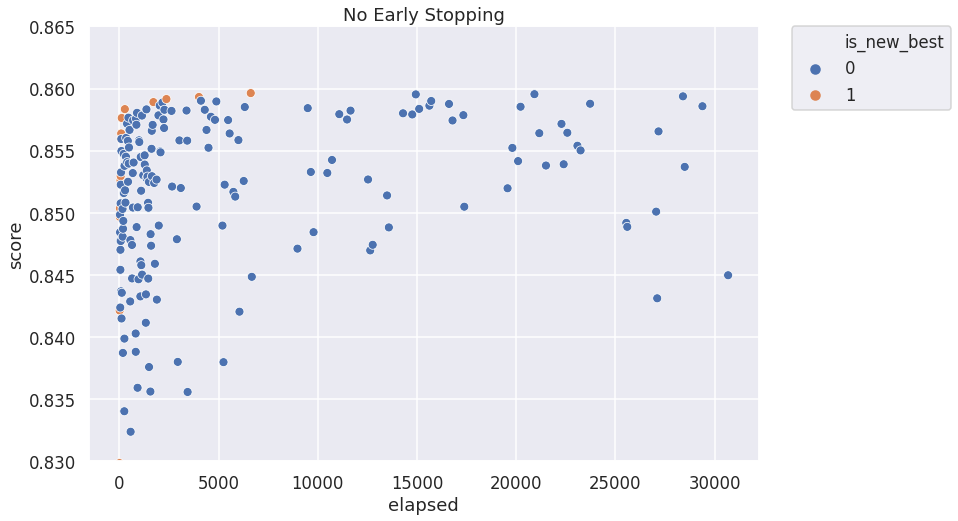

In [9]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("darkgrid")
sns.set_context("talk")
sns.scatterplot(data=df_no_es, x="elapsed", y='score', hue="is_new_best").set_title('No Early Stopping')
plt.ylim(0.83, 0.865)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Early Stopping

In [10]:
df_yes_es = get_df_from_log(log_fn="logs/tune_2021-09-30 20-05-50.544218.log")
df_yes_es.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trial              799 non-null    int64  
 1   score              799 non-null    float64
 2   duration           799 non-null    float64
 3   num_leaves         799 non-null    int64  
 4   min_child_samples  799 non-null    int64  
 5   learning_rate      799 non-null    float64
 6   max_bin            799 non-null    int64  
 7   colsample_bytree   799 non-null    float64
 8   reg_alpha          799 non-null    float64
 9   reg_lambda         799 non-null    float64
 10  n_estimators       799 non-null    int64  
 11  elapsed            799 non-null    float64
 12  is_new_best        799 non-null    int64  
dtypes: float64(7), int64(6)
memory usage: 81.3 KB


In [8]:
df_yes_es.head()

,trial,score,duration,num_leaves,min_child_samples,learning_rate,max_bin,colsample_bytree,reg_alpha,reg_lambda,n_estimators,elapsed,is_new_best
0,1,0.851916,11.700036,4,20,1.000000,8,0.100000,0.000977,1.000000,32768,11.700036,1
1,2,0.850744,13.531631,4,19,1.000000,8,0.178375,0.000977,0.738519,32768,25.231667,0
2,3,0.852062,21.326513,4,21,0.464425,17,0.021625,0.012129,1.354061,32768,46.558180,1
3,4,0.854952,18.974232,4,34,0.460277,12,0.161035,0.119698,0.508465,32768,65.532412,1
4,5,0.852188,22.876654,5,21,0.464425,17,0.021625,0.012129,1.354061,32768,88.409066,0


In [9]:
df_yes_es.sort_values('score', ascending=False).head(10)

,trial,score,duration,num_leaves,min_child_samples,learning_rate,max_bin,colsample_bytree,reg_alpha,reg_lambda,n_estimators,elapsed,is_new_best
47,48,0.860552,34.526792,21,14,0.095453,8,0.343715,1.674648,5.883155,32768,4104.435190,1
777,778,0.860408,37.523184,17,15,0.074665,8,0.371595,2.428785,7.820046,32768,29095.817781,0
741,742,0.860401,33.907525,14,15,0.078366,8,0.344939,1.263363,3.778044,32768,28040.715457,0
645,646,0.860374,34.280651,12,13,0.100307,8,0.344881,1.738308,6.254748,32768,24993.003109,0
341,342,0.860297,34.572489,16,17,0.066248,8,0.352212,3.018020,9.621311,32768,15388.442143,0
567,568,0.860290,44.043406,20,13,0.060126,9,0.328983,1.375353,5.113517,32768,22515.956739,0
770,771,0.860275,34.683977,16,14,0.090747,10,0.355570,1.386894,8.811436,32768,28863.809534,0
594,595,0.860260,35.180438,18,12,0.089145,10,0.355004,1.730080,3.262616,32768,23390.468742,0
318,319,0.860242,36.424525,24,14,0.070026,11,0.373750,2.779056,3.050168,32768,14716.934216,0
530,531,0.860220,32.645402,17,12,0.066181,8,0.329263,1.224836,4.481971,32768,21407.756693,0


In [11]:
df_yes_es.sort_values('score', ascending=False).head(10).to_markdown()

'|     |   trial |    score |   duration |   num_leaves |   min_child_samples |   learning_rate |   max_bin |   colsample_bytree |   reg_alpha |   reg_lambda |   n_estimators |   elapsed |   is_new_best |\n|----:|--------:|---------:|-----------:|-------------:|--------------------:|----------------:|----------:|-------------------:|------------:|-------------:|---------------:|----------:|--------------:|\n|  47 |      48 | 0.860552 |    34.5268 |           21 |                  14 |       0.0954531 |         8 |           0.343715 |     1.67465 |      5.88316 |          32768 |   4104.44 |             1 |\n| 777 |     778 | 0.860408 |    37.5232 |           17 |                  15 |       0.0746648 |         8 |           0.371595 |     2.42879 |      7.82005 |          32768 |  29095.8  |             0 |\n| 741 |     742 | 0.860401 |    33.9075 |           14 |                  15 |       0.0783664 |         8 |           0.344939 |     1.26336 |      3.77804 |          32768 |  28

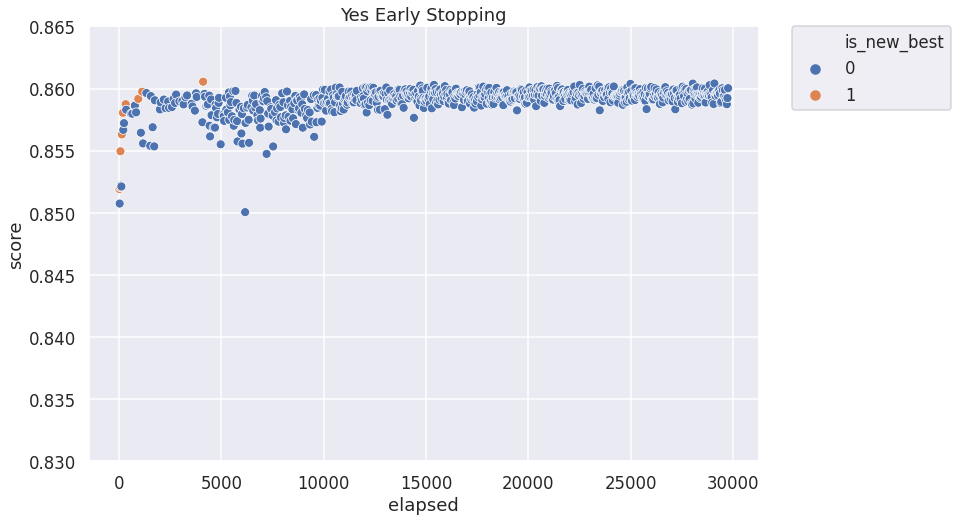

In [10]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("darkgrid")
sns.set_context("talk")
sns.scatterplot(data=df_yes_es, x="elapsed", y='score', hue="is_new_best").set_title('Yes Early Stopping')
plt.ylim(0.83, 0.865)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)